# Chip making for a subset of GB

This document extracts a series of chips for a region of GB and stores them as `numpy` arrays ready to be loaded by TensorFlow.

In [65]:
import tools
import geopandas
import contextily
import xarray, rioxarray
import numpy
import pandas
import pyogrio
from shapely.geometry import box

## Specs

In [35]:
specs = {
    'bb': box(321566, 365379, 468106, 437198),
    'chip_size': 32,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'spsig_p': (
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
    ),
    'tensor': (
        '/home/jovyan/work/urbangrammar_samba/'
        'spatial_signatures/chips/sample.npz'
    ),
}

## Load region

- Mosaic

In [36]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

- Region

In [37]:
region = r.sel(
    band=[1, 2, 3]
).rio.clip_box(
    *specs['bb'].bounds
).compute()

## Make chips

In [38]:
%%time
chips = tools.build_grid(
    region.coords['x'],
    region.coords['y'],
    specs['chip_size'],
    crs=region.rio.crs
)

CPU times: user 1.09 s, sys: 215 ms, total: 1.3 s
Wall time: 673 ms


## Filter through signatures

- Read signature layer

In [16]:
%%time
spsig = pyogrio.read_dataframe(specs['spsig_p'])

CPU times: user 989 ms, sys: 177 ms, total: 1.17 s
Wall time: 1.94 s


- Join chips to signatures by `within` to keep only single-class chips

In [55]:
%%time
oc_chips = geopandas.sjoin(
    chips, 
    spsig[['signature_type', 'geometry']], 
    how='inner', 
    predicate='within'
)

CPU times: user 5.16 s, sys: 190 ms, total: 5.35 s
Wall time: 4.28 s


---

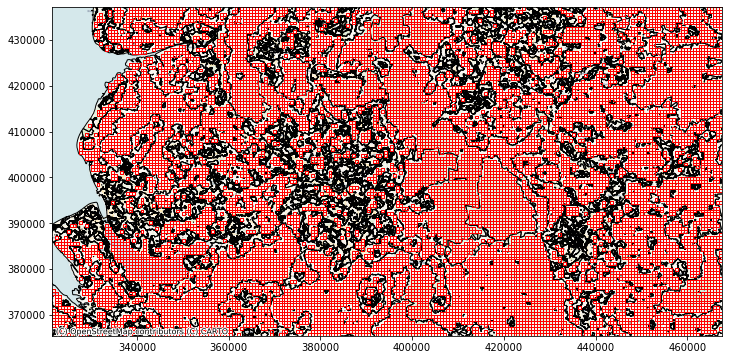

In [9]:
ax = spsig.plot(facecolor='none', edgecolor='k', figsize=(12, 12))
oc_chips.plot(facecolor='none', edgecolor='red', ax=ax)
minX, minY, maxX, maxY = oc_chips.total_bounds
ax.set_xlim((minX, maxX))
ax.set_ylim((minY, maxY))
contextily.add_basemap(
    ax, crs=oc_chips.crs, source=contextily.providers.CartoDB.Voyager
);

(365462.947432155, 437199.5895371777)

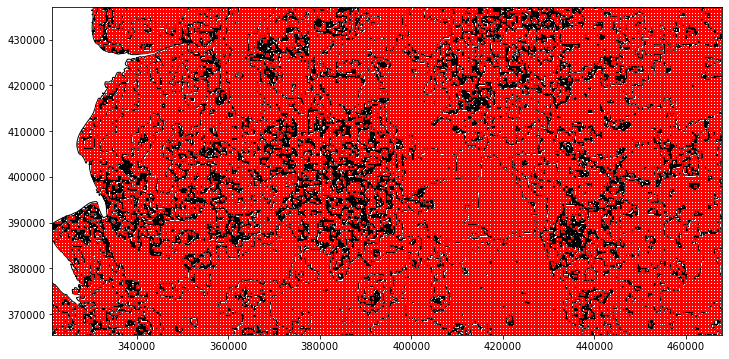

In [40]:
ax = spsig.plot(facecolor='none', edgecolor='k', figsize=(12, 12))
oc_chips.plot(facecolor='none', edgecolor='red', ax=ax)
minX, minY, maxX, maxY = oc_chips.total_bounds
ax.set_xlim((minX, maxX))
ax.set_ylim((minY, maxY))

## Load imagery into chips

In [6]:
from dask.distributed import Client, LocalCluster
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33583,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.55 GiB
Comm: tcp://172.17.0.2:42943,Total threads: 1
Dashboard: http://172.17.0.2:34637/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:42759,


In [56]:
%time out = tools.bag_of_chips(oc_chips, specs, 16)

CPU times: user 3.56 s, sys: 1.36 s, total: 4.92 s
Wall time: 9.13 s


Shuffle

In [59]:
numpy.random.seed(42)

shuffled_idx = numpy.arange(0, out.shape[0])
numpy.random.shuffle(shuffled_idx)

out = out[shuffled_idx]

Labels need to be an array of floats or ints with a shape (N, 1).

In [68]:
codes = pandas.Categorical(oc_chips.signature_type).codes
labels = codes[shuffled_idx].reshape((-1,1))

## Write to disk

Once ready, we store the array as a `.npz` file to be shipped to TensorFlow.

In [70]:
%%time
numpy.savez_compressed(specs["tensor"], labels=labels, chips=out)

CPU times: user 1min 19s, sys: 1.21 s, total: 1min 20s
Wall time: 1min 6s
